In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='ct'):
    adf_test = stt.adfuller(df.values,maxlag=maxlag, autolag=autolag, regression=regression)
#     print(adf_test)
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
    result = adf < cv_5
#     print(adf, '--', cv_5, result)
    return result


def d_param(df, max_lag=52):
    d = 0
    if ~is_stationary(df):
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;
    return d

def ARMA_params(df):
    p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()), max_ar=4, max_ma=2, ic='aic', trend='c').aic_min_order
    
    return p, q


# filePath = "Datasets/DS_AR2_ddddd1.csv"
# filePath = "Datasets/DS_AR2_ddddd2.csv"
# filePath = "Datasets/DS_AR2_ddddd3.csv"
# filePath = "Datasets/DS_AR2_ddddd4.csv"
filePath = "Datasets/DS_AR2_ddddd5_unique.csv"
# filePath = "Datasets/DS_AR2_ddddd6.csv"
# filePath = "Datasets/DS_AR2_ddddd7.csv"
# filePath = "Datasets/DS_AR2_ddddd8_unique.csv"
# filePath = "Datasets/DS_AR2_ddddd9_unique.csv"

csvFile = pd.read_csv(filePath)
print(csvFile)

     Unnamed: 0      Value
0             0   9.979729
1             1  10.169406
2             2   7.717077
3             3   6.871570
4             4   9.671073
..          ...        ...
335         335   9.314681
336         336   9.307611
337         337   7.925699
338         338   7.612362
339         339  10.720100

[340 rows x 2 columns]


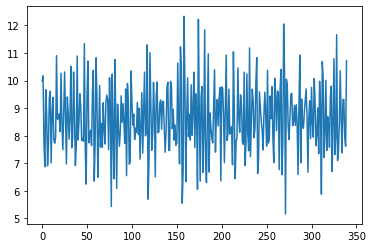

In [26]:
# df1 = csvFile['Births']
df1 = csvFile['Value']
X = df1.values
plt.plot(X)

ADF Statistic: -2.292629
p-value: 0.174356
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
False


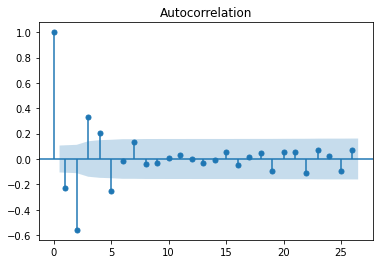

<Figure size 432x288 with 0 Axes>

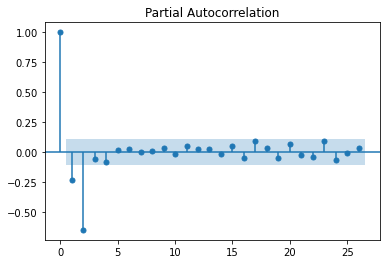

In [27]:
# result = adfuller(X, autolag='aic')
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

In [28]:
res = sm.tsa.arma_order_select_ic(df1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

(2, 0)
(2, 0)


In [29]:
trainRatio = .90
thresh = int(len(X)*trainRatio)
print(thresh)
X1 = df1[:thresh]
d = d_param(X1)

res = sm.tsa.arma_order_select_ic(X1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

d = min([2,d])
print(d)

306
0       9.979729
1      10.169406
2       7.717077
3       6.871570
4       9.671073
         ...    
301     8.480095
302     7.946383
303    10.070632
304     9.175155
305     7.633355
Name: Value, Length: 306, dtype: float64
(2, 0)
(2, 0)
2


In [30]:
p = 2
q = 0
print(p,d,q)

2 2 0


2 2 0
3.7879585883285887


Text(0, 0.5, 'Values')

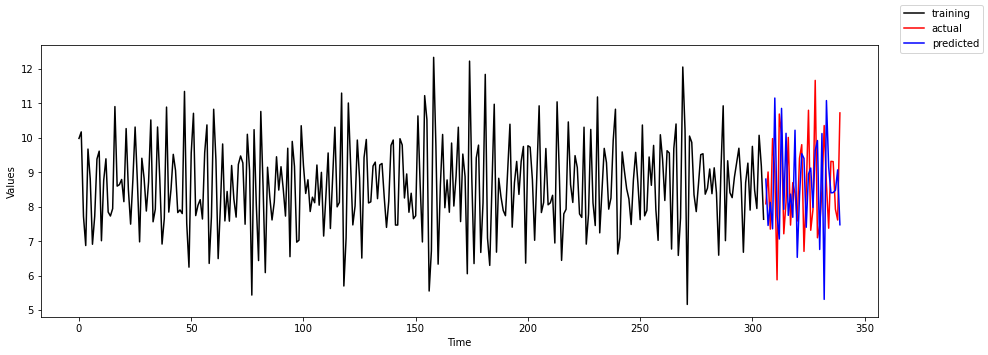

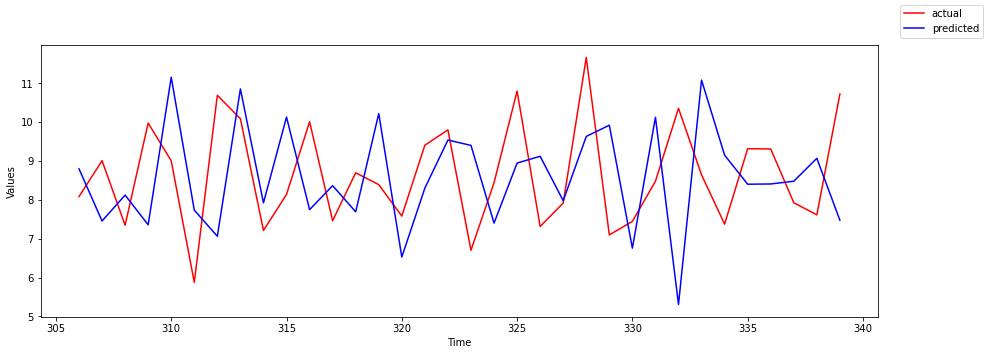

In [35]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])

    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)

    return mse_error, mape_error, train, test, predictions

p = 2
q = 0
d = 2
print(p,d,q)

arima_order = (p,d,q)

mse_error, mape_error, train, test, predictions = evaluate_arima_model(df1.values, arima_order, trainRatio)
print('MSE:', mse_error)
print('MAPE:', mape_error)


trainRange = np.arange(0,len(train),1)
testRange = np.arange(len(train), len(train) + len(test),1)
# print(trainRange)
# print(testRange)
ax = plt.figure(figsize=(15,5))
plt.plot(trainRange, train, 'k')
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax.legend(['training', 'actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')

ax1 = plt.figure(figsize=(15,5))
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax1.legend(['actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')